In [1]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 4.123759471808808e6 W/m²
ϕ(t=0): 0.0 ⋅ 2π
Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

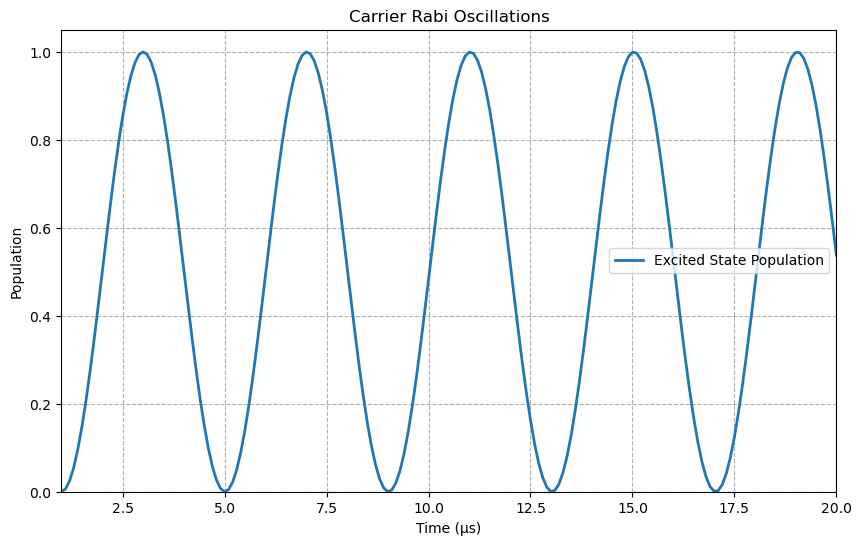

In [45]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

# 3. Define Experiment and Pulse Parameters
# Set the laser properties. The Pulse(T, w, I, phi, t) parameters from your
# request are set here as properties of the laser object.
# 'w' (frequency) is set by Δ (detuning) and λ (wavelength).
# 'I' (intensity) is set by E (E-field amplitude).
# 'phi' is set by L.ϕ.
# 't' (time-dependence) is handled by the solver over a time span `tspan`.
#L.k = (x̂ + ẑ)/√2       # Laser wavevector
#L.ϵ = (x̂ - ẑ)/√2       # Laser polarization

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
#L.λ = transitionwavelength(C, ("g", "e"), T) # Set laser wavelength to be resonant with the transition

# For a carrier transition, we set the detuning to zero.
#L.Δ = 0.0
#pi_time = 2.5e-6
#E_amplitude = 100000 #Efield_from_pi_time(pi_time, T, 1, 1, ("g", "e"))
#intensity!(L, t->E_amplitude) # This sets a constant (square) pulse
#print(L);

intensity_from_pitime!(L, 2e-6, C, ("g", "e"), T);
print(L);

# 4. Construct Hamiltonian and Run Simulation
# Set the Hilbert space dimension for the motional mode (max number of phonons)
#mode = zmodes(T)[1]
#mode.N = 10

# Construct the time-independent Hamiltonian for the system
# For a simple square pulse, the Hamiltonian is not time-dependent.
# We set a high rwa_cutoff to ensure all terms are included.
h = hamiltonian(T,timescale=1e-6, rwa_cutoff=Inf)

# Define the initial state: ion in the ground state |g⟩ and motional mode in
# the ground state |0⟩.
#ψ_mode = fockstate(mode[1].basis, 0)
#ψ₀ = C["g"] ⊗ ψ_mode


ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

# Define the time span for the simulation. We'll run it for two pi-times (5 µs)
# to see a full Rabi flop.
#tspan = 0:0.05e-6:5e-6

# t_cal_max = 10e-6 
# tspan = 0:t_cal_max/1000:t_cal_max

tspan = 1:0.1:20
# Solve the time evolution using the Schrödinger equation solver from QuantumOptics.jl
tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)

# 5. Analyze and Visualize the Results
# Calculate the population in the excited state |e⟩ over time
excited_pop = expect(ionprojector(T, "e"), sol)

# Create the plot using PyPlot
figure(figsize=(10, 6))
plot(tout, real.(excited_pop), label="Excited State Population", color="C0", linewidth=2)
xlim(tout[1], tout[end])
xlabel("Time (μs)")
ylabel("Population")
title("Carrier Rabi Oscillations")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()

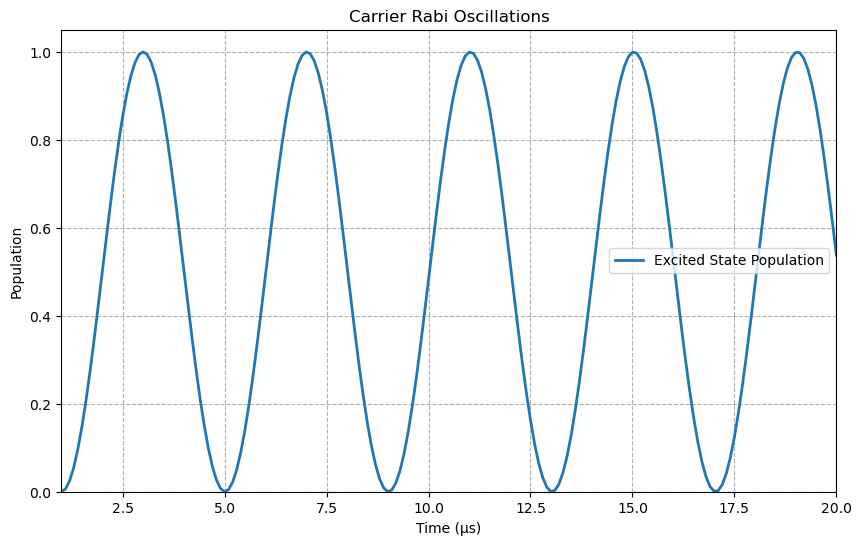

In [42]:

#ex = expect(ionprojector(T, "e"), sol)
# plot(tout, real.(excited_pop))
# xlim(tout[1], tout[end])
# ylim(0, 1)
# ylabel("Excitation")
# xlabel("Time (μs)");
# show()
h = hamiltonian(T,timescale=1e-6, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)

# 5. Analyze and Visualize the Results
# Calculate the population in the excited state |e⟩ over time
excited_pop = expect(ionprojector(T, "e"), sol)
figure(figsize=(10, 6))
plot(tout, real.(excited_pop), label="Excited State Population", color="C0", linewidth=2)
xlim(tout[1], tout[end])
xlabel("Time (μs)")
ylabel("Population")
title("Carrier Rabi Oscillations")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()

  0.008233 seconds (148.37 k allocations: 3.995 MiB)
ComplexF64[0.0 + 0.0im, 0.00614264030495801 + 0.0im, 0.024263240859776724 + 0.0im, 0.05345634584711675 + 0.0im, 0.0922669192155229 + 0.0im, 0.1387679964475596 + 0.0im, 0.19066223336029087 + 0.0im, 0.24540016684972618 + 0.0im, 0.30030703133407294 + 0.0im, 0.3527106065720639 + 0.0im, 0.4000646272094742 + 0.0im, 0.4400646850120482 + 0.0im, 0.4707550069872828 + 0.0im, 0.4906237756531217 + 0.0im, 0.4986826827584652 + 0.0im, 0.4945240767663355 + 0.0im, 0.4783484159600941 + 0.0im, 0.45095683196155717 + 0.0im, 0.41370793130276723 + 0.0im, 0.36844293048781374 + 0.0im, 0.31738696482282347 + 0.0im, 0.26303554384183436 + 0.0im, 0.20803375721210293 + 0.0im, 0.15505323569375903 + 0.0im, 0.10666982686766699 + 0.0im, 0.06524442009121624 + 0.0im, 0.032810438812281545 + 0.0im, 0.010972932292910914 + 0.0im, 0.0008254049986475333 + 0.0im, 0.002890100474836333 + 0.0im, 0.01708624251968975 + 0.0im, 0.04272895101505917 + 0.0im, 0.07855985294726248 + 0.0im,

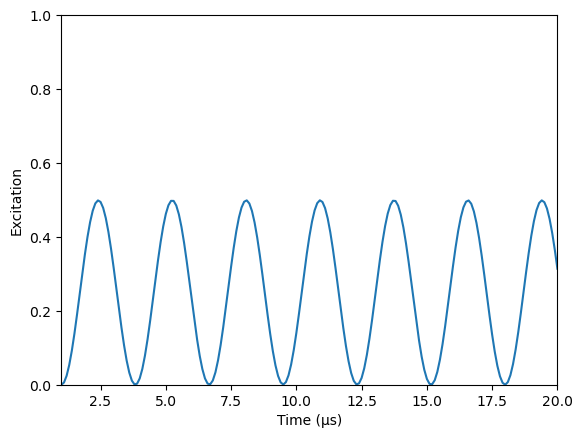

In [43]:
detuning!(L, 2.5e5)

h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)

ex = expect(ionprojector(T, "e"), sol)
println(ex)
print(tout)
plt.plot(tout, real.(ex))
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

  0.008686 seconds (148.37 k allocations: 3.995 MiB)


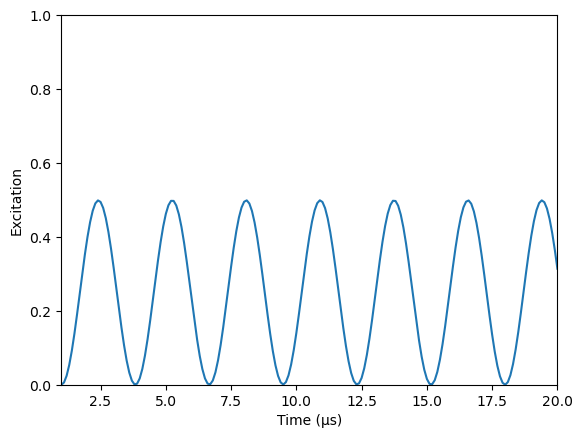

In [44]:
detuning!(L, 2.5e5)
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)

ex = expect(ionprojector(T, "e"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");